# Imports

In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Activation
from tensorflow.keras import Input, Model, backend as K
import numpy as np
import matplotlib.pyplot as plt
print("Tensorflow version: ", tf.__version__)
from IPython.display import display

from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.optimizers import RMSprop
from keras import backend as K

import matplotlib.pyplot as plt

import time
# Needed for saving
import pandas as pd

# In order to split the labels into training and testing sets
from sklearn.model_selection import train_test_split

# Enable the TPU
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
tf.config.experimental_connect_to_cluster(resolver)
# # This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)

print("All devices: ", *tf.config.list_logical_devices("TPU"), sep="\n\t")

Tensorflow version:  2.12.0
All devices: 
	LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU')
	LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU')
	LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU')
	LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU')
	LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU')
	LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU')
	LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU')
	LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU')


# Load in the data

In [2]:
# Get path by linking first, then selecting the file w/ right mouse button; 'get path'
labels = np.load('/content/drive/MyDrive/IDL/A1/labels.npy')
data = np.load('/content/drive/MyDrive/IDL/A1/images.npy')

# Shape for data input
# data.reshape(data.shape[0], *(150, 150, 1)).shape
data.shape

(18000, 150, 150)

In [ ]:
labels

array([[ 0,  0],
       [ 0,  0],
       [ 0,  0],
       ...,
       [11, 59],
       [11, 59],
       [11, 59]])

# Change of labels

In [3]:
def to_classification(labels, min_per_bin : int = 30):
  h, m = labels.T
  return 60//min_per_bin*h +m//min_per_bin


In [5]:
labels_30min = to_classification(labels, 30)
labels_30min[labels_30min == 0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
labels_1min = to_classification(labels, 1)
labels_1min[labels_1min == 0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0])

# Common sense time:

In [3]:
def common_sense_time(y_true, y_pred):
  predicted_min = y_pred[0]*60+y_pred[1]
  actual_min = y_true[0]*60+y_true[1]
  # Returns the difference in units of minutes
  return (actual_min - predicted_min)%720

In [16]:
common_sense_time([11, 55], [0, 5])
common_sense_time([0, 5], [11.01, 55])

9.399999999999977

#### Example of some clocks

In [ ]:
np.max(data[0,:,:]/255.0)

1.0

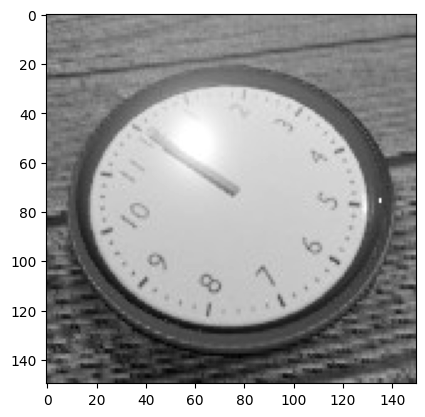

In [22]:
plt.imshow(data[0,:,:]/255.0, cmap='gray')
plt.show()
# plt.imshow(data[-1,:,:], cmap='gray')
# plt.show()
# plt.imshow(data[5000,:,:], cmap='gray')
# plt.show()

In [7]:
def make_model(arch, optimizer,
               metrics: list = ["accuracy"],
               steps_per_execution: int = 1,
               summary_model: bool = False,
               loss_function = 'sparse_categorical_crossentropy'):

  # Create a dictionary of possible layers. In this case we can create any arbitary network
  # without having to constantly copy and paste lines.
  layer_dict = {
        "dense": Dense,             # units, activation=None
        "dropout": Dropout,         # rate, noise_shape=None, seed=None
        "conv": Conv2D,             # filters, kernel_size, strides=(1, 1), padding="valid", activation=None
        "maxpooling": MaxPooling2D, # pool_size=(2, 2), strides=None, padding="valid"
        "flatten": Flatten,
        "BN": BatchNormalization,
  }

  ##########################################

  # Initiate model
  model = keras.models.Sequential()

  ## Add input layer
  model.add(Input(shape=arch['input_shape']))

  ## Add layers
  for layer, kwargs in arch['layers']:
    # Use our dictionary to obtain the callable layer and put in the keywords arguments
    model.add(layer_dict[layer](**kwargs))

  # Output layer
  model.add(layer_dict[arch['output'][0]](**arch['output'][1]))

  ##########################################

  # Print summary if wanted
  if summary_model:
    model.summary()

  model.compile(loss=loss_function,
                optimizer=optimizer,
                metrics=metrics,
                steps_per_execution=steps_per_execution)

  # Return model before fitting
  return model


def fit_model(model, X_train, y_train, scaling,
              epochs: int = 30, validation_split: float = 0.1,
              batch: int = 64, verbose: int = 0):

  history = model.fit(X_train/scaling, y_train, epochs=epochs,
                    validation_split = validation_split, batch_size=batch, verbose=verbose,
                    shuffle=True)

  return history


def eval_model(model, X_test, y_test, batch, verbose=1):
  return model.evaluate(X_test, y_test, batch_size=batch, verbose=verbose)


Given on Brightspace was the hint for having a number of parameters between 256 and 2048 for the last layer. Else the network would be too complex, leading to very long fitting times, as well as the possibility of having no convergence in a sufficient amount of time.

In [ ]:
classification_model_half_hours ={
    'input_shape':(150, 150, 1),
    # Output (we have in total 720 classes of time, 60*12, each with a given probability per item (returned by Softmax), but start by classes of 30 minutes)
    # Start with half hours
    'output': ('dense', {'units': 24, 'activation': 'softmax'}),

    'layers':[
        ('conv', {'filters': 9, 'kernel_size': 17, 'activation': 'relu'}),
        # An image has about 8 in height and 8 in width of freedom before having the clock in the image. So reduce the size using the kernel to have the clock in frame
        # Furthermore, 150/17 ~ 9, leaving 9 filters in total.
        ('maxpooling', {'pool_size': (2,2)}),

        # Now for the numbers on the clock. Say that a number is indicated in a size of about 15x15
        ('conv', {'filters': 12, 'kernel_size': 15, 'activation': 'relu'}),
        ('maxpooling', {'pool_size': (2,2)}),



        # Arrows on the clock. Given the 15x15 block we are in from the previous layer, make a kernel of 3x3
        # to seek the arrow indication. We need about 15*15/3*3 = 25 filters.
        ('conv', {'filters': 25, 'kernel_size': 3, 'activation': 'relu'}),
        ('maxpooling', {'pool_size': (2,2)}),




        ('conv', {'filters': 25, 'kernel_size': 3, 'activation': 'relu'}),
        ('maxpooling', {'pool_size': (2,2)}),

        ('conv', {'filters': 25, 'kernel_size': 3, 'activation': 'relu'}),
        ('maxpooling', {'pool_size': (2,2)}),

        ('flatten', {}),
        ('dense', {'units': 60, 'activation': 'relu'}),
        ('dropout', {'rate': 0.5}),
        ('dense', {'units': 40, 'activation': 'relu'}),
        ('dropout', {'rate': 0.5}),
    ]
}
make_model(classification_model_half_hours, optimizer=keras.optimizers.Adam(),
          steps_per_execution=250, summary_model=True)

# display(keras.utils.plot_model(make_model(classification_model, optimizer=keras.optimizers.Adam(),
#            steps_per_execution=100, summary_model=False), show_layer_activations=True))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 134, 134, 9)       2610      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 67, 67, 9)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 53, 53, 12)        24312     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 26, 26, 12)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 25)        2725      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 12, 25)       0

# 2A

Make a classification model

First make the labels applicable

In [3]:
def to_classification(labels, min_per_bin : int = 30):
  h, m = labels.T
  return 60//min_per_bin*h +m//min_per_bin

labels_1min = to_classification(labels, 1)
labels_1min[labels_1min == 0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0])

#### Make the classification model

In [4]:
def classification_model(input_shape):
  """
  Builds a classification model for time.

  This model is composed of three Conv -> BN -> Pool -> Dropout blocks,
  followed by the Dense output layer.

  # Output (we have in total 720 classes of time, 60*12, each with a given probability per item (returned by Softmax)
  """
  inputs = Input(shape=input_shape)
  x = Conv2D(16, (3, 3), padding="same")(inputs)
  x = Activation("relu")(x)
  x = BatchNormalization(axis=-1)(x)
  x = MaxPooling2D(pool_size=(3, 3))(x)
  x = Dropout(0.25)(x)
  x = Conv2D(32, (3, 3), padding="same")(x)
  x = Activation("relu")(x)
  x = BatchNormalization(axis=-1)(x)
  x = MaxPooling2D(pool_size=(2, 2))(x)
  x = Dropout(0.25)(x)
  x = Conv2D(32, (3, 3), padding="same")(x)
  x = Activation("relu")(x)
  x = BatchNormalization(axis=-1)(x)
  x = MaxPooling2D(pool_size=(2, 2))(x)
  x = Dropout(0.25)(x)
  # MLP part
  x = Flatten()(x)
  x = Dense(144)(x)
  x = Activation("relu")(x)
  x = BatchNormalization()(x)
  x = Dropout(0.25)(x)
  x = Dense(60)(x)
  x = Activation("relu")(x)
  x = BatchNormalization()(x)
  x = Dropout(0.25)(x)
  x = Dense(720)(x)
  x = Activation("softmax")(x)

  # An image has about 8 in height and 8 in width of freedom before having the clock in the image.
  # So reduce the size using the kernel to have the clock in frame
  # Furthermore, 150/17 ~ 9, leaving 9 filters in total.

  # # Now for the numbers on the clock. Say that a number is indicated in a size of about 15x15
  # x = Conv2D(64, (15, 15), padding="same")(x)
  # x = Activation("relu")(x)
  # x = BatchNormalization(axis=-1)(x)
  # x = MaxPooling2D(pool_size=(2, 2))(x)
  # x = Dropout(0.25)(x)

  # # Arrows on the clock. Given the 15x15 block we are in from the previous layer, make a kernel of 3x3
  # # to seek the arrow indication.
  # x = Conv2D(64, (5, 5), padding="same")(x)
  # x = Activation("relu")(x)
  # x = BatchNormalization(axis=-1)(x)
  # x = MaxPooling2D(pool_size=(2, 2))(x)
  # x = Dropout(0.25)(x)

  # # Add a final convolutional layer to further optimize the model
  # x = Conv2D(64, (5, 5), padding="same")(x)
  # x = Activation("relu")(x)
  # x = BatchNormalization(axis=-1)(x)
  # x = MaxPooling2D(pool_size=(2, 2))(x)
  # x = Dropout(0.25)(x)


  # # Flatten to go to the MLP part of our model
  # x = Flatten()(x)
  # x = Dropout(0.5)(x)
  # x = Dense(1480)(x)
  # x = Activation('relu')(x)
  # x = Dropout(0.5)(x)
  # x = Dense(720)(x)
  # x = Activation("relu")(x)
  # x = Dropout(0.5)(x)
  # x = Activation("softmax", name="classification_output")(x)

  model = Model(inputs=inputs,
                outputs = [x],
            )

  return model


In [5]:
class_mod = classification_model(input_shape=(150, 150, 1))
class_mod.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 150, 150, 16)      160       
                                                                 
 activation (Activation)     (None, 150, 150, 16)      0         
                                                                 
 batch_normalization (BatchN  (None, 150, 150, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 50, 50, 16)        0     

Compile

In [6]:
class_mod.compile(loss='sparse_categorical_crossentropy', # we have equal distribution of data, so no outliers (no need for MAE as loss function)
              optimizer=keras.optimizers.Adam(learning_rate=0.001,
                                              ), # Kwarg: 'decay' decreases the learning rate per epoch
              metrics=['accuracy'],
              steps_per_execution=100,
              )

#### Create training and test sets

In [7]:
X_train_classification, X_test_classification, y_train_classification, y_test_classification = train_test_split(
                                                      data, labels_1min, test_size=0.2, random_state=42
                                                                                                )

#### Train the model

In [8]:
history_model = class_mod.fit(X_train_classification/255.0, y_train_classification,
                            batch_size=32, validation_data=(X_test_classification/255.0, y_test_classification),
                            epochs=100, shuffle=True)

class_mod.save_weights('/content/drive/MyDrive/IDL/A1/weights_model_with_shuffle_2a.keras')


Epoch 1/100
450/450 [==============================] - 47s 105ms/step - loss: 6.6400 - accuracy: 0.0016 - val_loss: 15.6425 - val_accuracy: 0.0014
Epoch 2/100
450/450 [==============================] - 37s 83ms/step - loss: 6.4846 - accuracy: 0.0043 - val_loss: 6.4814 - val_accuracy: 0.0031
Epoch 3/100
450/450 [==============================] - 37s 83ms/step - loss: 6.1429 - accuracy: 0.0088 - val_loss: 6.0096 - val_accuracy: 0.0072
Epoch 4/100
450/450 [==============================] - 37s 82ms/step - loss: 5.7424 - accuracy: 0.0150 - val_loss: 6.3838 - val_accuracy: 0.0050
Epoch 5/100
450/450 [==============================] - 37s 82ms/step - loss: 5.2533 - accuracy: 0.0256 - val_loss: 5.1060 - val_accuracy: 0.0289
Epoch 6/100
450/450 [==============================] - 37s 82ms/step - loss: 4.7563 - accuracy: 0.0424 - val_loss: 7.0029 - val_accuracy: 0.0072
Epoch 7/100
450/450 [==============================] - 37s 82ms/step - loss: 4.3931 - accuracy: 0.0557 - val_loss: 8.0674 - val_

In [9]:
train_acc_2a = history_model.history['accuracy']
test_acc_2a = history_model.history['val_accuracy']

my_array = np.array(train_acc_2a)
filename = 'train_acc_2a.npy'
np.save('/content/drive/MyDrive/IDL/A1'+filename, my_array)

my_array = np.array(test_acc_2a)
filename = 'test_acc_2a.npy'
np.save('/content/drive/MyDrive/IDL/A1'+filename, my_array)

#### Visualize our results

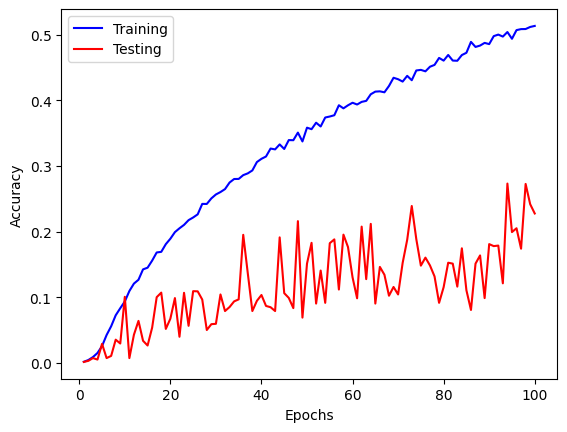

In [11]:
plt.plot(np.linspace(1, len(train_acc_2a), len(train_acc_2a)), train_acc_2a, color='blue', label='Training')
plt.plot(np.linspace(1, len(test_acc_2a), len(test_acc_2a)), test_acc_2a, color='red', label='Testing')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
# plt.yscale('log')
plt.show()

In [12]:
# Predict
y_pred_2a = class_mod.predict(data/255.0)

563/563 [==============================] - 10s 18ms/step


In [15]:
# Convert the softmax probability to a 'one-hot' solution
# we need to have labels of a highest probability class.
# Therefore, we use the argmax argument as the probability
# per class, 0 to 720, is between 0 and 1. The highest value
# is the prediction of minute classification.
predictions_classification = np.argmax(y_pred_2a, axis=1)
predictions_classification.shape

(18000,)

In [21]:
residuals_classification = labels_1min - predictions_classification

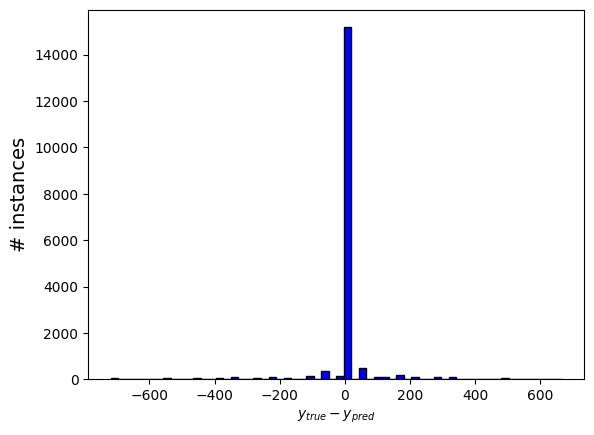

In [24]:
plt.hist(residuals_classification, bins=60, edgecolor='black', color='blue')
plt.xlabel(r"$y_{true}-y_{pred}$")
plt.ylabel("# instances", fontsize=14)
plt.show()

#### How many instances are correctly classified?

In [25]:
len(residuals_classification[residuals_classification == 0])

11204

# 2B

Make a regression model

First make the labels applicable

In [3]:
# Round off each minute as 1/60 = 0.0166666..., use round 3 to make regression speed up (there is no point using all decimals)
labels_regression = labels[:, 0] + np.round(labels[:, 1]/60, 3)

In [44]:
len(np.unique(labels_regression))

720

#### Histogram of labels:

(array([1800., 1800., 1800., 1800., 1800., 1800., 1800., 1800., 1800.,
        1800.]),
 array([ 0.    ,  1.1983,  2.3966,  3.5949,  4.7932,  5.9915,  7.1898,
         8.3881,  9.5864, 10.7847, 11.983 ]),
 <BarContainer object of 10 artists>)

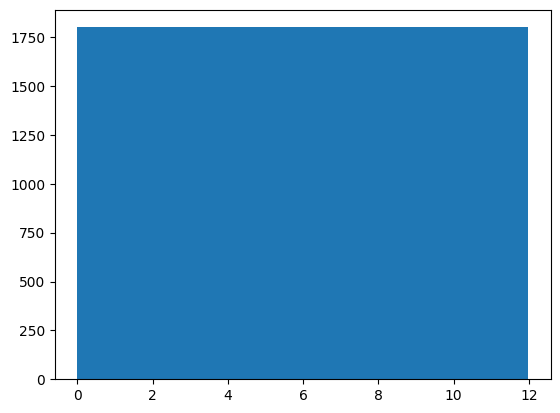

In [46]:
plt.hist(labels_regression)

### Create model

In [11]:
def regression_model(input_shape, default: bool = False):
        """
        Builds a regression model for floats of time.

        This model is composed of three Conv -> BN -> Pool -> Dropout blocks,
        followed by the Dense output layer.

        Last layer is a regression layer, output is only 1 value, activation function
        is linear.
        """
        inputs = Input(shape=input_shape)
        x = Conv2D(16, (3, 3), padding="same")(inputs)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=-1)(x)
        x = MaxPooling2D(pool_size=(3, 3))(x)
        x = Dropout(0.25)(x)
        x = Conv2D(32, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=-1)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.25)(x)
        x = Conv2D(32, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=-1)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.25)(x)

        x = Flatten()(x)

        if default:

          x = Dense(128)(x)
          x = Activation("relu")(x)
          x = BatchNormalization()(x)
          x = Dropout(0.5)(x)
          x = Dense(1)(x)
          x = Activation("linear", name="regression_output")(x)

        else:
          x = Dense(256)(x)
          x = Activation("relu")(x)
          x = BatchNormalization()(x)
          x = Dropout(0.5)(x)
          x = Dense(144)(x)
          x = Activation("relu")(x)
          x = BatchNormalization()(x)
          x = Dropout(0.5)(x)
          x = Dense(1)(x)
          x = Activation("linear", name="regression_output")(x)

        model = Model(inputs=inputs,
                     outputs = [x],
                  )
        return model


model_regression_default = regression_model(input_shape=(150,150, 1), default = True)
model_regression = regression_model(input_shape=(150,150, 1), default = False)


Display the model

In [12]:
model_regression_default.summary()
# display(keras.utils.plot_model(model_regression_default, show_layer_activations=True))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 1)]     0         
                                                                 
 conv2d_15 (Conv2D)          (None, 150, 150, 16)      160       
                                                                 
 activation (Activation)     (None, 150, 150, 16)      0         
                                                                 
 batch_normalization (BatchN  (None, 150, 150, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 50, 50, 16)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 50, 50, 16)        0     

In [13]:
# model_regression.summary()

Compile it: use a loss function of mean squared error (also try common sense error)

In [5]:
model_regression_default.compile(loss='mse', # we have equal distribution of data, so no outliers (no need for MAE as loss function)
              optimizer=keras.optimizers.Adam(learning_rate=0.0005,
                                              ), # Kwarg: 'decay' decreases the learning rate per epoch
              metrics=['mae', 'acc'],
              steps_per_execution=50,
              )

Split the train and test data - use 80%/20%

In [4]:
X_train_regression, X_test_regression, y_train_regression, y_test_regression = train_test_split(
                                                      data, labels_regression, test_size=0.2, random_state=42
                                                                                                )

(array([1441., 1442., 1435., 1436., 1427., 1438., 1431., 1447., 1450.,
        1453.]),
 array([ 0.    ,  1.1983,  2.3966,  3.5949,  4.7932,  5.9915,  7.1898,
         8.3881,  9.5864, 10.7847, 11.983 ]),
 <BarContainer object of 10 artists>)

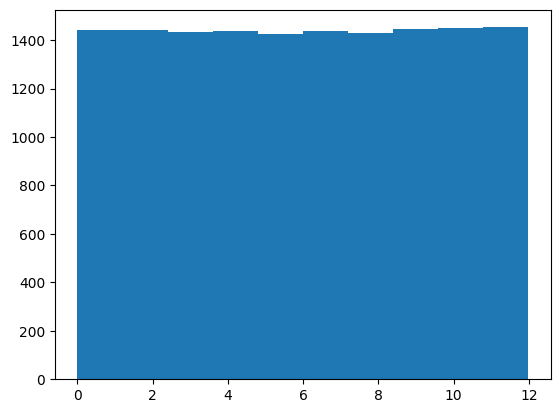

In [8]:
plt.hist(y_train_regression)

Fit the model

In [7]:
model_regression_default_with_shuffle = model_regression_default.fit(X_train_regression/255.0, y_train_regression,
                                                                      batch_size=32, validation_data=(X_test_regression/255.0, y_test_regression),
                                                                      epochs=50, shuffle=True)

Epoch 1/50
450/450 [==============================] - 37s 82ms/step - loss: 31.6280 - mae: 4.5982 - acc: 0.0017 - val_loss: 3620.7566 - val_mae: 57.5945 - val_acc: 8.3333e-04
Epoch 2/50
450/450 [==============================] - 37s 82ms/step - loss: 13.2185 - mae: 2.9615 - acc: 0.0015 - val_loss: 387.0799 - val_mae: 8.8942 - val_acc: 8.3333e-04
Epoch 3/50
450/450 [==============================] - 37s 81ms/step - loss: 11.6122 - mae: 2.7571 - acc: 0.0015 - val_loss: 245.4721 - val_mae: 8.7011 - val_acc: 0.0011
Epoch 4/50
450/450 [==============================] - 37s 81ms/step - loss: 10.5253 - mae: 2.6189 - acc: 0.0015 - val_loss: 564.1527 - val_mae: 17.5646 - val_acc: 0.0017
Epoch 5/50
450/450 [==============================] - 37s 81ms/step - loss: 9.8146 - mae: 2.5087 - acc: 0.0015 - val_loss: 10.1799 - val_mae: 2.5483 - val_acc: 8.3333e-04
Epoch 6/50
450/450 [==============================] - 36s 81ms/step - loss: 9.1823 - mae: 2.4192 - acc: 0.0015 - val_loss: 12.1735 - val_mae: 

Save the weights

In [9]:
model_regression_default.save_weights('/content/drive/MyDrive/IDL/A1/weights_model_regression_with_shuffle_2b.keras')

Visualize the performance

In [10]:
train_mae = model_regression_default_with_shuffle.history['mae']
test_mae = model_regression_default_with_shuffle.history['val_mae']

In [14]:
my_array = np.array(train_mae)
filename = 'train_mae_2b.npy'
np.save('/content/drive/MyDrive/IDL/A1'+filename, my_array)

my_array = np.array(test_mae)
filename = 'test_mae_2b.npy'
np.save('/content/drive/MyDrive/IDL/A1'+filename, my_array)

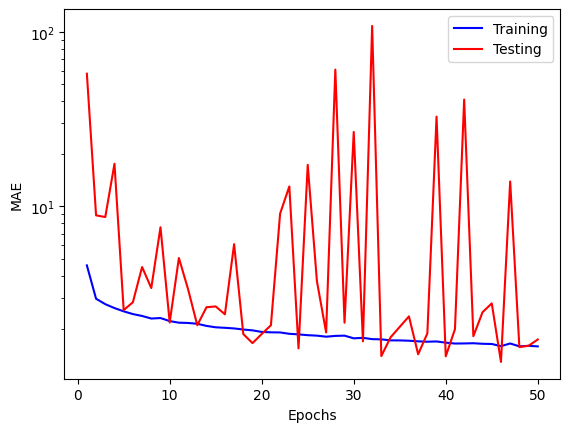

In [15]:
plt.plot(np.linspace(1, len(train_mae), len(train_mae)), train_mae, color='blue', label='Training')
plt.plot(np.linspace(1, len(train_mae), len(train_mae)), test_mae, color='red', label='Testing')
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.yscale('log')
plt.show()

Evaluate the model. Check if we are returned with a float between 0 and 11.9999....

In [22]:
y_pred = model_regression_default.predict(data/255.0)

563/563 [==============================] - 10s 18ms/step


In [24]:
residuals = labels_regression - y_pred.reshape(18000)

In [30]:
pd.DataFrame(residuals).describe()

,0
count,18000.000000
mean,-0.754591
std,2.000193
min,-33.304306
25%,-1.912417
50%,-0.725991
75%,0.408276
max,20.944242


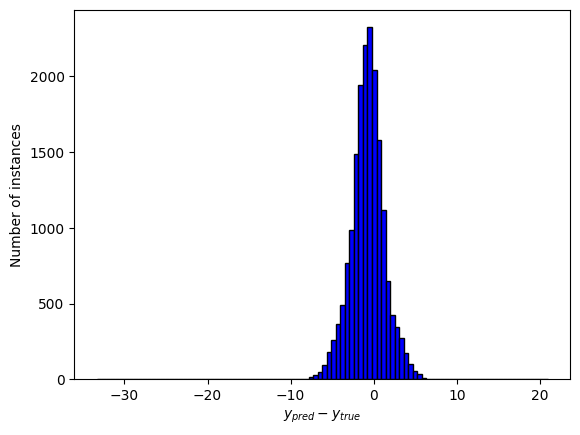

In [27]:
plt.hist(residuals, bins=100, edgecolor='black', color='blue')
plt.xlabel(r"$y_{pred} - y_{true}$")
plt.ylabel("Number of instances")
plt.show()

## Using a less complex architecture, the CNN of Fashion MNIST, p461 book.

Try using a less complex architecture, i.e. the CNN of task 1. We modify it using the following:
- adjusting the input shape to (150, 150, 1)
- a larger kernel size for the first convolutional layer
- the addition of batch normalization after each block of convolution and maxpooling. It is used to reduce overfitting, as well as improving the time needed to fit the neural network weights.
- reduce the number of filters in the original model
- increase the number of layers (or blocks of conv, maxpool and BN) before flatening
- change the final layer to a dense node (1) with a linear activation function. This is required for regression.

In [11]:
model_CNN_fashion_MNIST = keras.models.Sequential([
                  keras.layers.Conv2D(64, 10, activation="relu", padding="same",
                  input_shape=[150, 150, 1]),
                  keras.layers.MaxPooling2D(2),
                  keras.layers.BatchNormalization(),
                  keras.layers.Conv2D(128/2, 5, activation="relu", padding="same"),
                  keras.layers.MaxPooling2D(2),
                  keras.layers.BatchNormalization(),
                  keras.layers.Conv2D(128/2, 5, activation="relu", padding="same"),
                  keras.layers.MaxPooling2D(2),
                  keras.layers.BatchNormalization(),
                  keras.layers.Conv2D(128/2, 5, activation="relu", padding="same"),
                  keras.layers.MaxPooling2D(2),
                  keras.layers.BatchNormalization(),
                  keras.layers.Conv2D(128/2, 5, activation="relu", padding="same"),
                  keras.layers.MaxPooling2D(2),
                  keras.layers.Flatten(),

                  keras.layers.Dense(120, activation="relu"),
                  keras.layers.Dropout(0.5),
                  keras.layers.Dense(60, activation="relu"),
                  keras.layers.Dropout(0.5),

                  # Change the final layer to linear in order to have regression
                  keras.layers.Dense(1, activation="linear")
                  ])

In [12]:
model_CNN_fashion_MNIST.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 150, 150, 64)      6464      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 75, 75, 64)       0         
 2D)                                                             
                                                                 
 batch_normalization_4 (Batc  (None, 75, 75, 64)       256       
 hNormalization)                                                 
                                                                 
 conv2d_6 (Conv2D)           (None, 75, 75, 64)        102464    
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 37, 37, 64)       0         
 2D)                                                             
                                                      

Compile, fit and plot results

Epoch 1/40
450/450 [==============================] - 281s 625ms/step - loss: 17.0785 - mae: 3.3775 - val_loss: 22.9266 - val_mae: 3.8927
Epoch 2/40
450/450 [==============================] - 274s 609ms/step - loss: 13.0390 - mae: 2.9010 - val_loss: 76.7810 - val_mae: 7.9739
Epoch 3/40
450/450 [==============================] - 274s 609ms/step - loss: 11.0752 - mae: 2.6616 - val_loss: 11.3277 - val_mae: 2.7198
Epoch 4/40
450/450 [==============================] - 274s 610ms/step - loss: 9.1182 - mae: 2.3769 - val_loss: 11.5792 - val_mae: 2.6803
Epoch 5/40
450/450 [==============================] - 274s 610ms/step - loss: 7.0476 - mae: 2.0545 - val_loss: 15.4680 - val_mae: 3.2018
Epoch 6/40
450/450 [==============================] - 274s 608ms/step - loss: 5.9726 - mae: 1.8670 - val_loss: 8.1155 - val_mae: 2.1629
Epoch 7/40
450/450 [==============================] - 274s 609ms/step - loss: 4.8209 - mae: 1.6542 - val_loss: 13.0205 - val_mae: 3.0393
Epoch 8/40
450/450 [===================

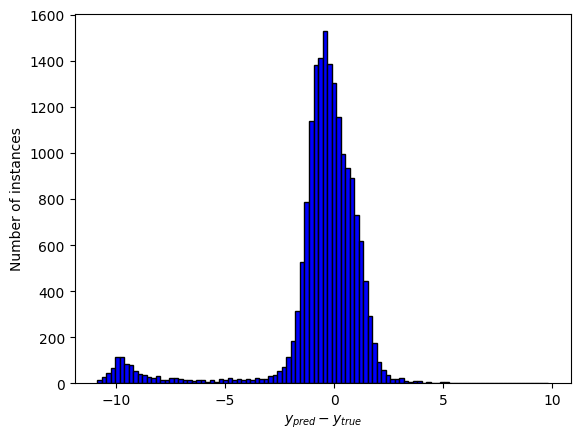

NameError: ignored

In [13]:
model_CNN_fashion_MNIST.compile(loss='mse', # we have equal distribution of data, so no outliers (no need for MAE as loss function)
              optimizer=keras.optimizers.Adam(learning_rate=0.001,
                                              ), # Kwarg: 'decay' decreases the learning rate per epoch
              metrics=['mae'],
              steps_per_execution=100,
              )

# Fit
history_fashion_MNIST = model_CNN_fashion_MNIST.fit(X_train_regression/255.0, y_train_regression,
                            batch_size=32, validation_data=(X_test_regression/255.0, y_test_regression),
                            epochs=40, shuffle=True)

# Save weights
model_CNN_fashion_MNIST.save_weights('/content/drive/MyDrive/IDL/A1/model_CNN_fashion_MNIST_regression_2b.keras')

# Save the values of mae for training and validation
train_mae2 = history_fashion_MNIST.history['mae']
test_mae2 = history_fashion_MNIST.history['val_mae']

my_array = np.array(train_mae2)
filename = 'train_mae_2_2b.npy'
np.save('/content/drive/MyDrive/IDL/A1'+filename, my_array)

my_array = np.array(test_mae2)
filename = 'test_mae_2_2b.npy'
np.save('/content/drive/MyDrive/IDL/A1'+filename, my_array)

# Predict
y_pred2 = model_CNN_fashion_MNIST.predict(data/255.0)
residuals2 = labels_regression - y_pred2.reshape(18000)

# Visualize
plt.hist(residuals2, bins=100, edgecolor='black', color='blue')
plt.xlabel(r"$y_{pred} - y_{true}$")
plt.ylabel("Number of instances")
plt.show()



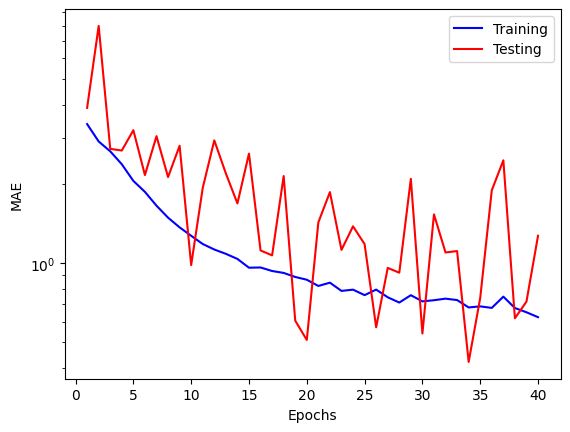

,0
count,18000.000000
mean,-0.615667
std,2.261487
min,-10.861156
25%,-0.928891
50%,-0.284081
75%,0.487810
max,9.806069


In [15]:
## plot 2

plt.plot(np.linspace(1, len(train_mae2), len(train_mae2)), train_mae2, color='blue', label='Training')
plt.plot(np.linspace(1, len(train_mae2), len(train_mae2)), test_mae2, color='red', label='Testing')
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.yscale('log')
plt.show()

pd.DataFrame(residuals2).describe()

# 2C

Idea: make 2 branches after the input, one branch for hours, one for minutes.

In [4]:
class MultiOutputModel():
    """
    Used to generate a multi-output model. This CNN contains two branches, one for hours, and the other for
    minutes. Each branch contains a sequence of Convolutional Layers that is defined
    on the make_default_hidden_layers method.
    """
    def make_default_hidden_layers(self, inputs):
        """
        Used to generate a default set of hidden layers.
        The structure used in this network is defined as:
          - Conv2D -> BatchNormalization -> Pooling -> Dropout
        """
        x = Conv2D(16, (3, 3), padding="same")(inputs)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=-1)(x)
        x = MaxPooling2D(pool_size=(3, 3))(x)
        x = Dropout(0.25)(x)
        x = Conv2D(32, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=-1)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.25)(x)
        x = Conv2D(32, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=-1)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.25)(x)
        return x

    def build_minutes_branch(self, inputs):
        """
        Builds the minutes branch. Use the structure of our model from 2b
        as inspiration of this branch.

        This branch is composed of Conv -> Pool -> BN -> Dropout blocks,
        followed by the Dense output layers.

        Last layer is a regression layer, output is only 1 value, activation function
        is linear.
        """
        x = Conv2D(64, (10, 10), padding="same")(inputs)
        x = Activation("relu")(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = BatchNormalization(axis=-1)(x)
        x = Conv2D(64, (5, 5), padding="same")(x)
        x = Activation("relu")(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = BatchNormalization(axis=-1)(x)
        x = Conv2D(64, (5, 5), padding="same")(x)
        x = Activation("relu")(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = BatchNormalization(axis=-1)(x)
        x = Conv2D(64, (5, 5), padding="same")(x)
        x = Activation("relu")(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = BatchNormalization(axis=-1)(x)

        # Flatten to go to MLP part
        x = Flatten()(x)
        x = Dense(128)(x)
        x = Activation("relu")(x)
        x = Dropout(0.5)(x)
        x = Dense(64)(x)
        x = Activation("relu")(x)
        x = Dropout(0.5)(x)
        x = Dense(1)(x)
        x = Activation("linear", name="minute_output")(x)
        return x

    def build_hour_branch(self, inputs, num_hours=12):
        """
        Builds the hour branch.

        This branch is composed of three Conv -> BN -> Pool -> Dropout blocks,
        followed by the Dense output layer.

        Last layer is softmax, as we want to classify each clock's hour
        using a hour class
        """
        x = self.make_default_hidden_layers(inputs)
        # MLP part
        x = Flatten()(x)
        x = Dense(144)(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.25)(x)
        x = Dense(60)(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.25)(x)
        x = Dense(num_hours)(x)
        x = Activation("softmax", name="hour_output")(x)
        return x

    def assemble_full_model(self, input_shape, num_hours):
        """
        Used to assemble our multi-output model CNN.
        """
        inputs = Input(shape=input_shape)
        hour_branch = self.build_hour_branch(inputs, num_hours)
        minute_branch = self.build_minutes_branch(inputs)

        model = Model(inputs=inputs,
                     outputs = [hour_branch, minute_branch],
                  )

        return model

model = MultiOutputModel().assemble_full_model(input_shape=(150, 150, 1), num_hours=12)


#### Summary of model:

In [4]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 150, 150, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 activation (Activation)        (None, 150, 150, 16  0           ['conv2d[0][0]']                 
                                )                                                             

#### Image of model:

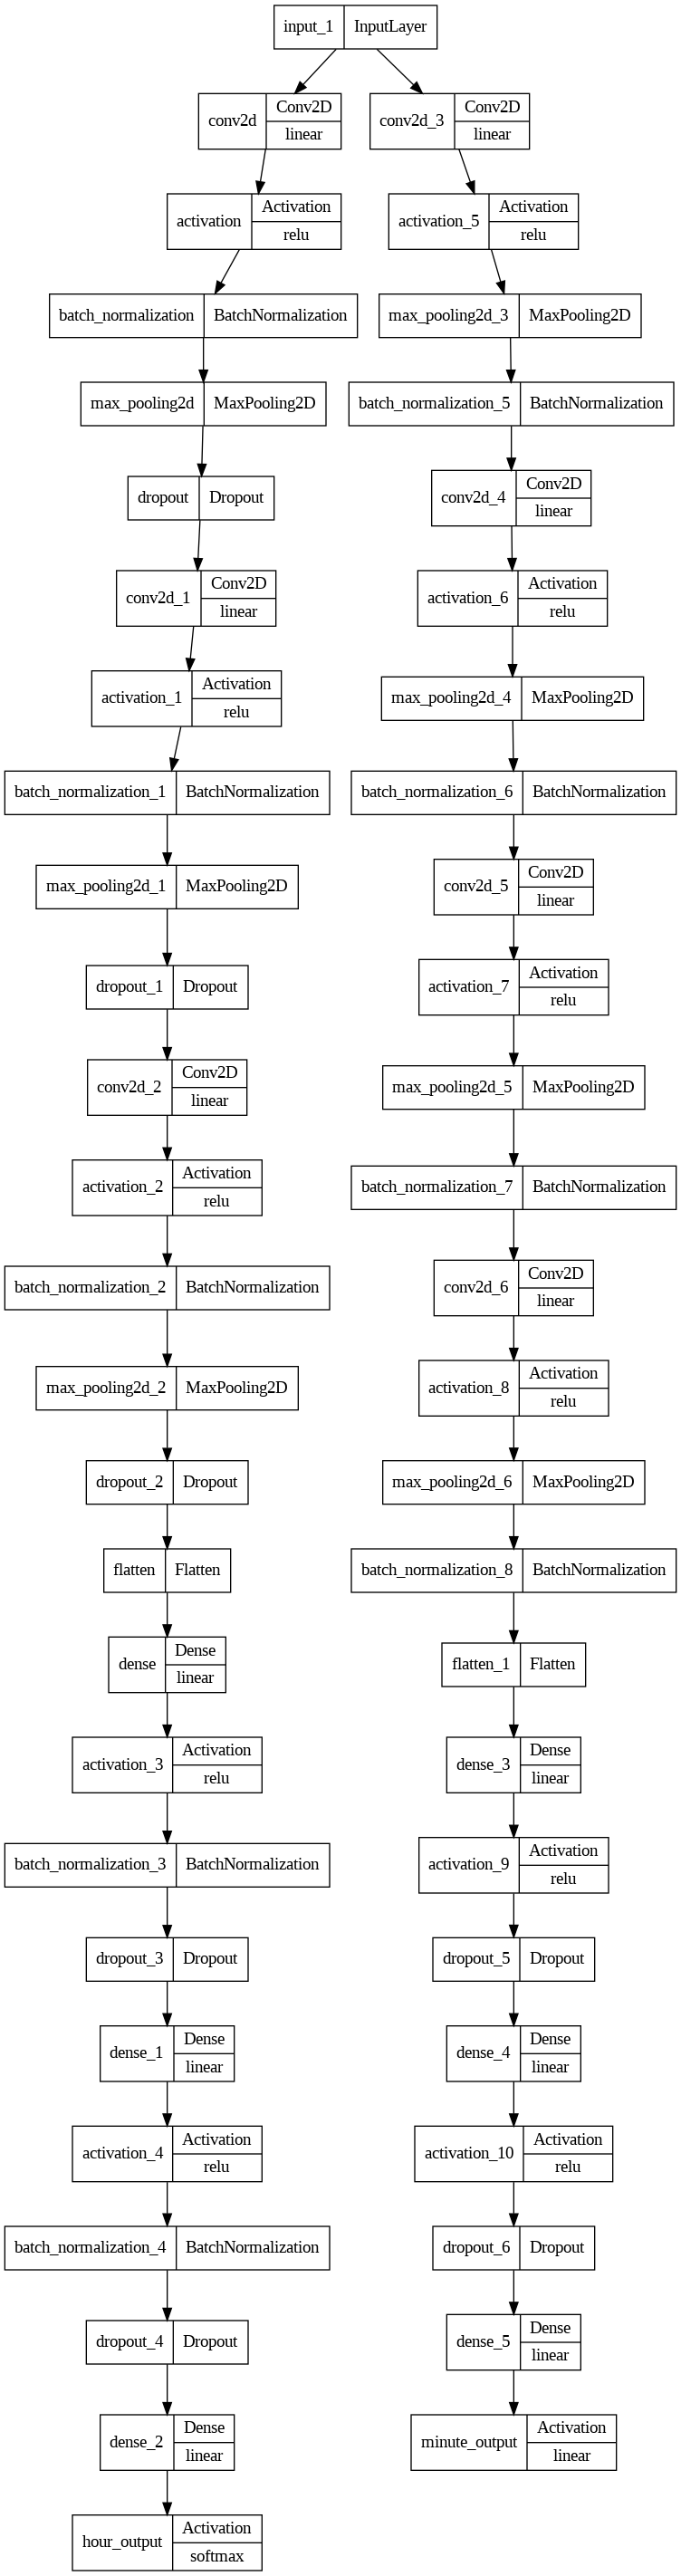

In [5]:
display(keras.utils.plot_model(model, show_layer_activations=True))

#### Compile the model

Use sparse categorical cross entropy for the hour class, since we have a classification problem. Furthermore, for the regression problem, use the mean squared error. As optimizer use Adam, it is a fine working optimizer, and has a high accuracy for task 1, which also included images. In addition, use the accuracy and mean absolute error. Utilize our TPU by setting the steps per execution to 50.

In [5]:
model.compile(loss={'hour_output': 'sparse_categorical_crossentropy',
                    'minute_output': 'mse'},
              optimizer=keras.optimizers.Adam(learning_rate=0.001),
              metrics={'hour_output': 'accuracy',
                    'minute_output': 'mae'},
              steps_per_execution=50,
              )

#### It is 'time' to make 2 labelled classes, we have an hours class, this is the first column of our labeled set, labels[:, 0]. Our second labels are found for minutes. Furthermore, make 80/20% train and test sets.

In [6]:
labels_h = labels[:,0]
labels_m = labels[:,1]

# Split the data
X_train, X_test, y_train_m, y_test_m, y_train_h, y_test_h = train_test_split(data, labels_m, labels_h, test_size=0.2, random_state=42)

####Fit the model using two kinds of labels

In [7]:
history_2c = model.fit(X_train/255.0, [y_train_h, y_train_m], batch_size=32, validation_data=(X_test/255.0, [y_test_h, y_test_m]), epochs=40, shuffle=True)

# model.save_weights('/content/drive/MyDrive/IDL/A1/weights_model_with_shuffle_2c_V2.keras')



Epoch 1/40
450/450 [==============================] - 280s 623ms/step - loss: 397.7430 - hour_output_loss: 2.7336 - minute_output_loss: 395.0092 - hour_output_accuracy: 0.0979 - minute_output_mae: 16.4697 - val_loss: 397.7491 - val_hour_output_loss: 21.3103 - val_minute_output_loss: 376.4388 - val_hour_output_accuracy: 0.0814 - val_minute_output_mae: 16.0411
Epoch 2/40
450/450 [==============================] - 268s 595ms/step - loss: 321.8497 - hour_output_loss: 2.4003 - minute_output_loss: 319.4496 - hour_output_accuracy: 0.1416 - minute_output_mae: 14.3562 - val_loss: 408.2964 - val_hour_output_loss: 2.2663 - val_minute_output_loss: 406.0300 - val_hour_output_accuracy: 0.1653 - val_minute_output_mae: 16.7102
Epoch 3/40
450/450 [==============================] - 267s 594ms/step - loss: 284.8666 - hour_output_loss: 2.1352 - minute_output_loss: 282.7315 - hour_output_accuracy: 0.2043 - minute_output_mae: 13.3481 - val_loss: 343.7588 - val_hour_output_loss: 2.1089 - val_minute_output_lo

KeyError: ignored

In [8]:
# Save the values of mae for training and validation
train_mae_2c_minutes = history_2c.history['minute_output_mae']
test_mae_2c_minutes = history_2c.history['val_minute_output_mae']

train_acc_2c_hour = history_2c.history['hour_output_accuracy']
test_acc_2c_hour = history_2c.history['val_hour_output_accuracy']

my_array = np.array(train_mae_2c_minutes)
filename = 'train_mae_2c.npy'
np.save('/content/drive/MyDrive/IDL/A1'+filename, my_array)

my_array = np.array(train_acc_2c_hour)
filename = 'train_accuracy_2c.npy'
np.save('/content/drive/MyDrive/IDL/A1'+filename, my_array)

my_array = np.array(test_mae_2c_minutes)
filename = 'test_mae_2c.npy'
np.save('/content/drive/MyDrive/IDL/A1'+filename, my_array)

my_array = np.array(test_acc_2c_hour)
filename = 'test_acc_2c.npy'
np.save('/content/drive/MyDrive/IDL/A1'+filename, my_array)

#### Load in the weights from the saved file

In [7]:
model.load_weights('/content/drive/MyDrive/IDL/A1/weights_model_with_shuffle_2c_V2.keras')

In [8]:
# Predict
y_pred_2c = model.predict(data/255.0)

563/563 [==============================] - 18s 32ms/step


In [9]:
y_pred_2c

[array([[5.1114202e-01, 5.6376499e-03, 4.2168751e-05, ..., 1.2129779e-04,
         4.4286661e-03, 4.7856703e-01],
        [2.7594188e-01, 3.2577524e-04, 1.6882204e-06, ..., 1.7776227e-05,
         3.9732745e-03, 7.1970731e-01],
        [5.1277316e-01, 4.5202729e-01, 1.2335481e-02, ..., 4.8920518e-04,
         9.1706868e-04, 1.9533444e-02],
        ...,
        [8.9139247e-01, 1.6543247e-02, 5.5580444e-05, ..., 2.7242340e-06,
         9.8556797e-05, 9.1825143e-02],
        [7.6184601e-02, 4.3747359e-04, 4.3617194e-05, ..., 5.8150245e-04,
         3.4494471e-02, 8.8763469e-01],
        [1.5004164e-03, 1.5126478e-02, 2.1582921e-01, ..., 6.9828644e-02,
         8.4846299e-03, 9.9442143e-04]], dtype=float32),
 array([[35.193714],
        [41.397984],
        [48.22253 ],
        ...,
        [27.367405],
        [46.023224],
        [48.731026]], dtype=float32)]

In [25]:
y_pred_2c[1].shape

(18000, 1)

In [12]:
# Convert the softmax probability to a 'one-hot' solution
# we need to have labels of a highest probability class.
# Therefore, we use the argmax argument as the probability
# per class, 0 to 11, is between 0 and 1. The highest value
# is the prediction of hours.
predictions_h = np.argmax(y_pred_2c[0], axis=1)
predictions_h.shape

(18000,)

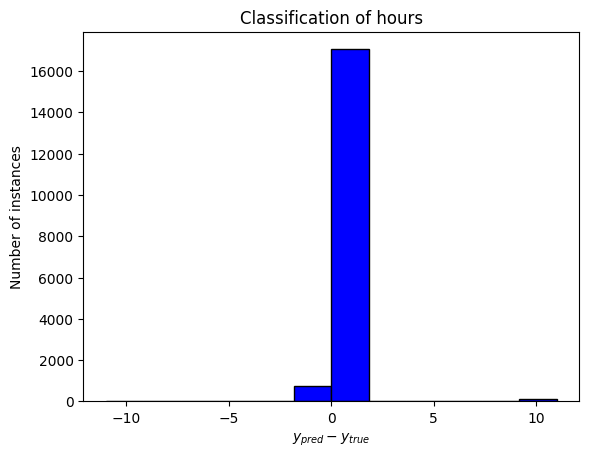

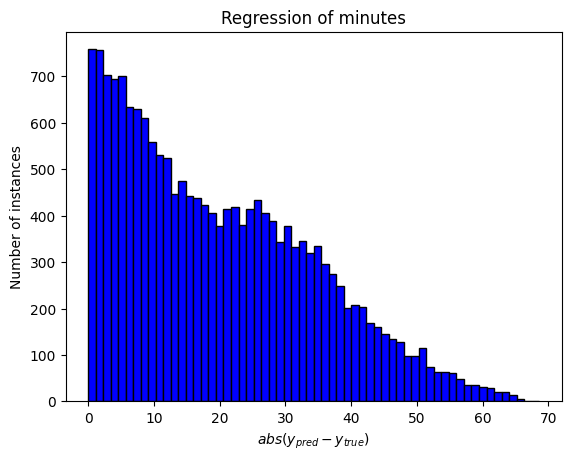

In [13]:
residuals_2c_h = predictions_h - labels[:,0]
residuals_2c_m = abs(y_pred_2c[1].reshape(18000) - labels[:,1])

# Visualize
plt.title("Classification of hours")
plt.hist(residuals_2c_h, bins=12, edgecolor='black', color='blue')
plt.xlabel(r"$y_{pred} - y_{true}$")
plt.ylabel("Number of instances")
plt.show()

plt.title("Regression of minutes")
plt.hist(residuals_2c_m, bins=60, edgecolor='black', color='blue')
plt.xlabel(r"$abs(y_{pred} - y_{true})$")
plt.ylabel("Number of instances")
plt.show()


#### How many instances are correctly classified for hours?


In [16]:
len(residuals_2c_h[residuals_2c_h == 0])

16419

#### What is the absolute mean of the minute residuals? In addition, how many instances are between 0 and 10?

In [18]:
np.mean(residuals_2c_m)

19.94577563370599

In [20]:
len([x for x in residuals_2c_m if 0 < x < 10])

5911

#### MAE and Accuracy of minutes and hours classes growth over epoch:

In [26]:
## plot 2

train_mae_2c = np.load('/content/drive/MyDrive/IDL/A1train_mae_2c.npy')
test_mae_2c = np.load('/content/drive/MyDrive/IDL/A1test_mae_2c.npy')

train_accuracy_2c = np.load('/content/drive/MyDrive/IDL/A1train_accuracy_2c.npy')
test_accuracy_2c = np.load('/content/drive/MyDrive/IDL/A1test_acc_2c.npy')



plt.plot(np.linspace(1, len(train_mae_2c), len(train_mae_2c)), train_accuracy_2c, color='blue', label='Training')
plt.plot(np.linspace(1, len(train_mae_2c), len(train_mae_2c)), test_accuracy_2c, color='red', label='Testing')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.yscale('log')
plt.show()

plt.plot(np.linspace(1, len(train_mae_2c), len(train_mae_2c)), train_mae_2c, color='blue', label='Training')
plt.plot(np.linspace(1, len(train_mae_2c), len(train_mae_2c)), test_mae_2c, color='red', label='Testing')
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.yscale('log')
plt.show()

OSError: ignored

In [23]:
pd.DataFrame(residuals_2c_h).describe()

,0
count,18000.000000
mean,0.052833
std,1.035745
min,-11.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,11.000000


In [24]:
pd.DataFrame(residuals_2c_m).describe()

,0
count,18000.000000
mean,19.945776
std,14.652596
min,0.001759
25%,7.299370
50%,17.400555
75%,30.324621
max,68.589371


#### Common sense error report:

In [41]:
def common_sense_time(y_true, y_pred):
  predicted_min = y_pred[:, 0]*60+y_pred[:,1]
  actual_min = y_true[:,0]*60+y_true[:,1]
  # Returns the difference in units of minutes
  return (predicted_min-actual_min)%720

y_pred_2c_together = np.array(list(zip(predictions_h, y_pred_2c[1].reshape(18000).astype(int))))
y_pred_2c_together

array([[ 0, 35],
       [11, 41],
       [ 0, 48],
       ...,
       [ 0, 27],
       [11, 46],
       [ 3, 48]])

In [42]:
np.mean(common_sense_time(labels, y_pred_2c_together))

220.3016111111111